# Create HAdamard encoding 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS


# For simulation, create a random parent amino acid sequence to create SOLD libraries from

This is an example of a fully in silico path to test and understand the simulator. The functions in the simulator are written such that we can develop models from a given SOLD matrix.
Deep mutational scan at multiple locaitons also conform to the SOLD matrix abstraction 

## Pretend that a set of positions in the protein is mutated--create a sythesis SOLD matrix

In [2]:
length_of_protein = 100
num_mutated = 5
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, mut_probs = [0.20, 0.20, 0.20, 0.20], parent_prob=0.20) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 
    

Parent protein: GVTSIFGDYCVKPVCLALGVGFYILHDWTYRRAHNKNAYCPAVSSFYSAAHVTHQYNYEFSAKAQEVLHNECFTIILVINWTFTAWDYKNVVCWKDKVTL
Random mutaed positions [ 9 14 36 61 90]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

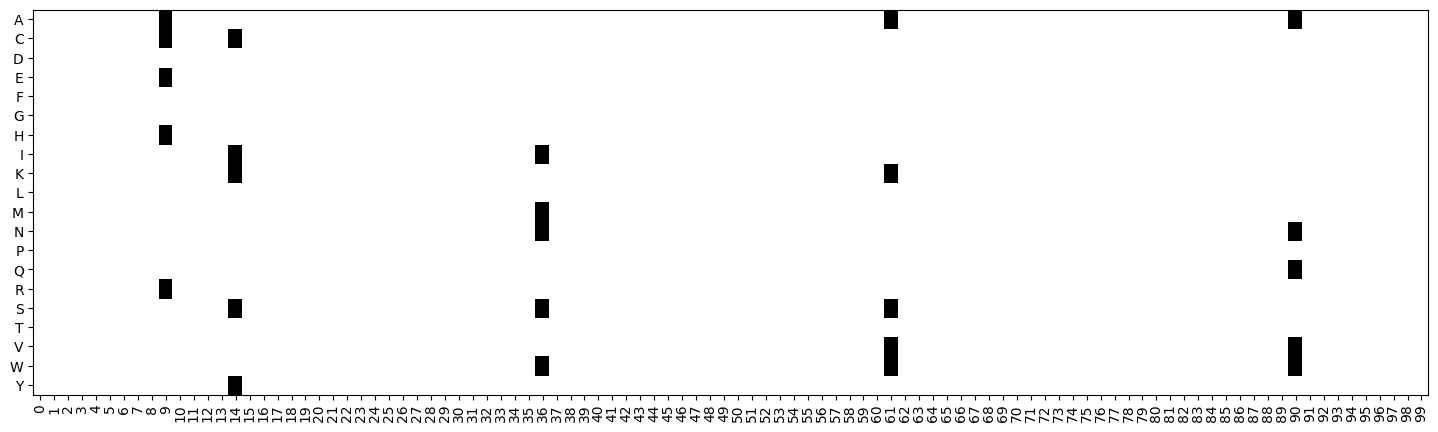

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's try to draw mutated sequences from this matrix 

Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentalist provided SOLD mat

In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)

In [5]:
seqs[0]

'RCIKW'

In [6]:
probs = S.compute_prob_n_mutations(num_mutated+1)

Text(0.5, 1.0, 'Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat')

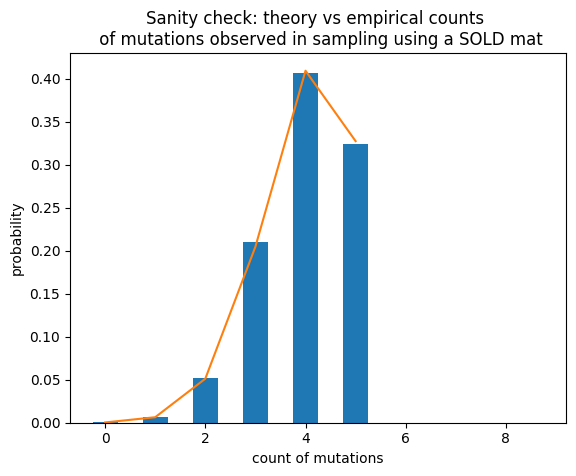

In [7]:
plt.hist(mutations, bins= np.array(range(10)) - 0.25, density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(probs)
plt.title("Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat")

# Now I need to provide weights to the independent and pairwise contributions

I create a mixture of pdfs to draw from, with a zero component (meaning not all independent and pairwise contributions have differential activity compared to parent, some have no effect, and one can control this effect size or model complexity in these simulations) 
Create a mixture of weigthts with random components and some sparse components 

In [14]:
from doe_utils import create_masked_features, H_20

class create_in_silico_model: 
    """
    Create an in silico model for simulation with independent and pairwise (epistatic) contributions 
    """
    def __init__(self, mutated_region_length, mutation_probs_variable_region_dict, independent_params = None, pairwise_params = None): 
        """
        Args:
            mutated_region_length: the length of ONLY the variable region (mutated region) of the protein, NOT the whole protein length! 
            mutation_probs ..  : pass the dict of mutation probs (this is generated by SOLD matrix class, attribute dict is called mutation_probs_variable_region_indexed) 
                example:
                {0: {'D': 0.05, 'K': 0.85, 'M': 0.05, 'Y': 0.05},
                 1: {'C': 0.05, 'G': 0.05, 'I': 0.05, 'P': 0.85},
                 2: {'F': 0.05, 'N': 0.05, 'R': 0.85, 'Y': 0.05},
                 3: {'G': 0.05, 'I': 0.05, 'L': 0.85, 'Q': 0.05},
                 4: {'A': 0.05, 'E': 0.05, 'R': 0.05, 'W': 0.85},
                 5: {'A': 0.05, 'D': 0.05, 'I': 0.85, 'K': 0.05}}
                where the keys are the index of the mutated regions and the values are dicts of probs of each amino acid
            idependent_params: {'rho':[0.2, 0.2], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
            pairwise_params: {'rho':[0.1, 0.1], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 
            
        """
        # independent params pdf default --- 
        I_defaults = {'rho':[0.2, 0.2], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
        #pairwise params pdf default ---
        P_defaults = {'rho':[0.2, 0.2], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 

        self.mutated_region_length = mutated_region_length 

        if independent_params is not None: 
            I_defaults.update(independent_params) 
        self.independent_params = I_defaults.copy()  

        if pairwise_params is not None: 
            P_defaults.update(pairwise_params) 
        # see the create mixture function
        self.pairwise_params = P_defaults.copy() 

        assert len(mutation_probs_variable_region_dict) == self.mutated_region_length, "The dict passed is invalid, length mismatch" 
        self.mutation_probs_variable_region_dict = mutation_probs_variable_region_dict
        self.independent_mask, self.pairwise_mask, self.feature_names_independent, self.feature_names_pairwise = \
        create_masked_features(self.mutated_region_length, self.mutation_probs_variable_region_dict)
        # These are the possibe features in combination 
        self.amino_product = [''.join(x) for x in product(AMINO_ACIDS, AMINO_ACIDS)]
        self.pos_product = [np.asarray(x) for x in combinations(np.arange(mutated_region_length), 2)]

        # Now I need to create the codes for the amino acids, using Hadamard matrix, drom the first column which is constant 
        single_base_code_mat = H_20[:, 1:] # these are the codes for AMINO_ACIDS 
        double_base_code_mat = np.kron(single_base_code_mat, single_base_code_mat) # for AMINO_ACID pairs 
        # Notice that order in maintained in itertools.product and np.kron --- I checked--- this double_base_code_mat should now be assigned to the products 
        # This is truly how we genralize to other interaction combinations 

        # Now I need to collect all of this in codes for every position that actually appear in the 

        
        # Note, i need to drop the constant first column and only take 20 other columns --- you ca
        
        # now create weights 
        # self.Prob_I = create_mixture(**self.independent_params)
        # I_samples, _ = self.Prob_I.samples(np.prod(self.shape_independent_weights))         

        # Now create the pairwise component weights! 
        
       
        #self.shape_pairwise_weights  = (len(self.amino_product), len(self.pos_product))
        
        
        
        # now create weights 
        # self.Prob_P = create_mixture(**self.pairwise_params)
        # P_samples, _ = self.Prob_P.samples(np.prod(self.shape_pairwise_weights))             

        
        # zero out independent weights not in mask 

        self.independent_weights = np.copy(self.raw_independent_weights)
        self.independent_weights[~self.independent_mask] = 0 # only keep the masked weights 
        independent_vals = _create_zero_mean_indepedent_feature_weights(self.raw_independent_weights[self.independent_mask], self.feature_names_independent) 
        self.independent_weights[self.independent_mask] = independent_vals
        
        # now normalize pairwise masks 
        pairwise_vals, _ = _create_zero_mean_pairwise_weights(self.raw_pairwise_weights[self.pairwise_mask], self.feature_names_pairwise, self.feature_names_independent)

        self.pairwise_weights = np.copy(self.raw_pairwise_weights) 
        self.pairwise_weights[self.pairwise_mask] = pairwise_vals
        self.pairwise_weights[~self.pairwise_mask] = 0 

        self.ground_truth_params = np.concatenate((np.ravel(self.independent_weights[self.independent_mask]), np.ravel(self.pairwise_weights[self.pairwise_mask])))
        

    def model(self, independent_codes, pairwise_codes, masked = False): 
        """
        Args: 
            independent_codes: the result of encoding my sequence encoder to independent codes --- these are tensors--- N seqs times A amino acids time L positions (shape_independet_weights) etc. 
            pairwise_codes: similar 
            masked: ignore the weights of independent and pairwise positions that are not variable! 
        """
        ans1 = np.einsum('ijk, jk -> i', independent_codes, self.independent_weights) 
        ans2 = np.einsum('ijk, jk -> i', pairwise_codes, self.pairwise_weights)
        return ans1 + ans2 
        
    def plot_weights(self): 
        """
        Plotting functions 
        """
        I_samples = np.ravel(self.raw_independent_weights) 
        GRID_SIZE = 1000
        x = np.linspace(np.min(I_samples), np.max(I_samples), GRID_SIZE)
        plt.figure() 
        plt.plot(x, self.Prob_I.pdf()(x))
        _ = plt.hist(I_samples, density=True, bins = 50)        
        plt.title('Distribution of unmaked independent weights') 

        P_samples = np.ravel(self.raw_pairwise_weights) 
        x = np.linspace(np.min(P_samples), np.max(P_samples), GRID_SIZE)
        plt.figure() 
        plt.plot(x, self.Prob_P.pdf()(x))
        _ = plt.hist(P_samples, density=True, bins = 50)        
        plt.title('Distribution of unmasked pairwise weights') 
        # weights 
        plt.figure() 
        plt.imshow(self.independent_weights, vmin = -1, vmax = 1, cmap = 'RdBu') 
        _  = plt.xticks(range(self.mutated_region_length), rotation = 90)
        _  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)
        plt.title("Independent weights") 
        plt.colorbar() 
        plt.figure(figsize = (5, 70))
        plt.imshow(self.pairwise_weights, vmin = -1, vmax = 1, cmap = 'RdBu', aspect = 'auto') 
        _  = plt.xticks(range(len(self.pos_product)), self.pos_product, rotation = 90)
        _  = plt.yticks(range(len(self.amino_product)), self.amino_product)
        plt.title("Pairwise weights") 
        #plt.colorbar




In [16]:
single_base_code_mat = H_20[:, 1:] 
double_base_code_mat = np.kron(single_base_code_mat, single_base_code_mat)



In [19]:
double_base_code_mat[10]

array([-1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,
       -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,
        1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,
        1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,
       -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1,
        1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,
       -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1,
       -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,
        1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,
        1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,
        1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,
        1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1,
       -1,  1,  1,  1,  1

In [32]:
amino_product = [''.join(x) for x in product(AMINO_ACIDS, AMINO_ACIDS)]
amino_product[200]

'MA'

In [33]:
AMINO_ACIDS[10]

'M'

In [34]:
np.all(np.kron(single_base_code_mat[10], single_base_code_mat[0]) == double_base_code_mat[200])

np.True_

In [13]:
I_params = {'rho':[0.49, 0.49], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
P_params = {'rho':[0.49, 0.49], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 


Model_in_silico = doe_utils.create_in_silico_model(num_mutated, S.mutation_probs_variable_region_indexed, independent_params=I_params, pairwise_params=P_params)
Model_in_silico.plot_weights()

NameError: name '_create_zero_mean_indepedent_feature_weights' is not defined

In [ ]:
Model_in_silico.independent_params

# Now compute respose for a bunch of seqs

Need to eocnde the sequeces into pairwise and independent features 


# ENCODE

In [ ]:
Encoder = doe_utils.sequence_encoder(num_mutated)
encodings = Encoder.encode_seqs(seqs) # this produces two lists --- the first 1 is the independent encodings, the second one is pairwise encodings 

In [ ]:
responses = Model_in_silico.model(encodings[0], encodings[1], masked= True) 

In [ ]:
_ = plt.hist(responses, bins = 25)
plt.title("in silico responses (indel activity)") 

# Now do sparse (elastic net) linear regression to learn back the weights 

In [ ]:
fit_model = doe_utils.fitting_model(S.mutation_probs_variable_region_indexed)
fitted_params, fit_responses = fit_model.fit(seqs, responses)

plt.figure() 
plt.imshow(fit_model.constraints, aspect = 'auto', cmap = 'Greys', interpolation = 'None') 
plt.figure() 
plt.scatter(Model_in_silico.ground_truth_params, fitted_params)
plt.xlabel("ground truth") 
plt.ylabel("fitted params") 



In [ ]:
np.sum(Model_in_silico.pairwise_weights, axis =1)

In [ ]:
import scipy 

plt.plot(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)))

plt.title('Null space problem, we have zero eigenvalues in feature matrix')
plt.yscale('log')

In [ ]:
plt.scatter(fitted_params[fit_model.pairwise_indices], Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask])
plt.title('Pairwise params') 

In [ ]:
a,b  = doe_utils._create_zero_mean_pairwise_weights(Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask], Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)
c,d = doe_utils._create_zero_mean_pairwise_weights(fitted_params[fit_model.pairwise_indices], Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)

In [ ]:
plt.plot(b)
plt.plot(d)

In [ ]:
d

In [ ]:
plt.scatter(fitted_params[fit_model.independent_indices], Model_in_silico.independent_weights[Model_in_silico.independent_mask])
plt.title('independent params')

In [ ]:
plt.plot(fit_responses, responses)

In [ ]:
np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001)

In [ ]:
print("Cant account for ... ") 

np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001) -np.shape(fit_model.constraints)[0]

In [ ]:
np.shape(Model_in_silico.pairwise_weights)

In [ ]:
np.shape(fit_model.constraints)

In [ ]:
np.shape(fit_model.independent_indices)

In [ ]:
np.shape(fit_model.pairwise_indices)

In [ ]:
import re

A = np.asarray([re.split(':' + "|" + '-', a) for a in Model_in_silico.feature_names_pairwise]) 

collector = [] 
for a in A: 
    if a[1] != a[3]:
        collector.append(a)
    

In [ ]:
np.shape(fit_model.independent_indices)

In [ ]:
ij = [a+b for a,b in zip(A[:,1],A[:,3])]
len(np.unique(ij))

In [ ]:
np.unique([[a,b] for a,b in zip(A[:,0], A[:,2])], axis = 0)

In [ ]:
A[:, [0, 2]]

In [ ]:
inds = np.all(A[:, [0,2]] == ['0', '1'], axis = 1)
inds

In [ ]:
A[inds]

In [ ]:

plt.figure(figsize = (5, 70))
plt.imshow(encodings[1][0], aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 1, cmap = 'Greys')
_  = plt.xticks(range(len(Encoder.pos_product)), Encoder.pos_product, rotation = 90)
_  = plt.yticks(range(len(Encoder.amino_product)), Encoder.amino_product)
plt.title(seqs[0]) 

In [ ]:
plt.imshow(encodings[0][0])

In [ ]:
np.max([1,2,3])